Ce projet permettra d'entrainer un modèle pour prédire si une banque peut accorder un prêt à un client ou pas selon la base de données "loan prediction problem DataSet" de kaggle

In [ ]:
# importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import LabelEncoder  # permet de remplacer des valeurs par des 0, 1, 2, ...
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score # permet de calculer la performance
from sklearn.model_selection import StratifiedShuffleSplit
import pickle # permet de save le ML medel(serialization et deserialization)

# lire la base de donnee
train = pd.read_csv('/content/train_u6lujuX_CVtuZ9i.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Exploration du dataSet

In [ ]:
# Comptabilise les valeurs manquants
train_null_count = train.isnull().sum().sort_values()
train_null_count

Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
Married               3
Gender               13
Loan_Amount_Term     14
Dependents           15
LoanAmount           22
Self_Employed        32
Credit_History       50
dtype: int64

In [ ]:
# afficher les valeurs numerics pour verifier s'il ya des valeurs anormales
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [ ]:
# afficher les variables categories
train.describe(include='O')


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001813,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


Traitement du dataSet

In [ ]:
# separer le dataSet en 2 sets: une avec les valeurs numeric et l'autre avec les valeurs categories
num_train = []
cate_train = []
# iterer sur le type des donnees et les classer dans chaque liste
for i,x in enumerate(train.dtypes):
  if x == object:
    cate_train.append(train.iloc[:,i])
  else:
    num_train.append(train.iloc[:,i]) 
num_train

[0      5849
 1      4583
 2      3000
 3      2583
 4      6000
        ... 
 609    2900
 610    4106
 611    8072
 612    7583
 613    4583
 Name: ApplicantIncome, Length: 614, dtype: int64, 0         0.0
 1      1508.0
 2         0.0
 3      2358.0
 4         0.0
         ...  
 609       0.0
 610       0.0
 611     240.0
 612       0.0
 613       0.0
 Name: CoapplicantIncome, Length: 614, dtype: float64, 0        NaN
 1      128.0
 2       66.0
 3      120.0
 4      141.0
        ...  
 609     71.0
 610     40.0
 611    253.0
 612    187.0
 613    133.0
 Name: LoanAmount, Length: 614, dtype: float64, 0      360.0
 1      360.0
 2      360.0
 3      360.0
 4      360.0
        ...  
 609    360.0
 610    180.0
 611    360.0
 612    360.0
 613    360.0
 Name: Loan_Amount_Term, Length: 614, dtype: float64, 0      1.0
 1      1.0
 2      1.0
 3      1.0
 4      1.0
       ... 
 609    1.0
 610    1.0
 611    1.0
 612    1.0
 613    0.0
 Name: Credit_History, Length: 614, dtype: float

In [ ]:
# transformer les listes en dataframe
num_train = pd.DataFrame(num_train)
cate_train = pd.DataFrame(cate_train)
num_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613
ApplicantIncome,5849.0,4583.0,3000.0,2583.0,6000.0,5417.0,2333.0,3036.0,4006.0,12841.0,3200.0,2500.0,3073.0,1853.0,1299.0,4950.0,3596.0,3510.0,4887.0,2600.0,7660.0,5955.0,2600.0,3365.0,3717.0,9560.0,2799.0,4226.0,1442.0,3750.0,4166.0,3167.0,4692.0,3500.0,12500.0,2275.0,1828.0,3667.0,4166.0,3748.0,...,6406.0,3159.0,3087.0,3229.0,1782.0,3182.0,6540.0,1836.0,3166.0,1880.0,2787.0,4283.0,2297.0,2165.0,4750.0,2726.0,3000.0,6000.0,9357.0,3859.0,16120.0,3833.0,6383.0,2987.0,9963.0,5780.0,416.0,2894.0,5703.0,3676.0,12000.0,2400.0,3400.0,3987.0,3232.0,2900.0,4106.0,8072.0,7583.0,4583.0
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0,4196.0,1516.0,2504.0,1526.0,10968.0,700.0,1840.0,8106.0,2840.0,1086.0,0.0,0.0,0.0,0.0,3500.0,0.0,5625.0,1911.0,1917.0,2925.0,0.0,2253.0,1040.0,0.0,2083.0,3369.0,0.0,0.0,1667.0,3000.0,2067.0,1330.0,1459.0,7210.0,1668.0,...,0.0,461.0,2210.0,2739.0,2232.0,2917.0,0.0,33837.0,0.0,0.0,1917.0,3000.0,1522.0,0.0,0.0,0.0,3416.0,0.0,0.0,3300.0,0.0,0.0,1000.0,0.0,0.0,0.0,41667.0,2792.0,0.0,4301.0,0.0,3800.0,2500.0,1411.0,1950.0,0.0,0.0,240.0,0.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0,267.0,95.0,158.0,168.0,349.0,70.0,109.0,200.0,114.0,17.0,125.0,100.0,76.0,133.0,115.0,104.0,315.0,116.0,112.0,151.0,191.0,122.0,110.0,35.0,120.0,201.0,74.0,106.0,114.0,320.0,NaN,100.0,144.0,184.0,110.0,...,150.0,108.0,136.0,110.0,107.0,161.0,205.0,90.0,36.0,61.0,146.0,172.0,104.0,70.0,94.0,106.0,56.0,205.0,292.0,142.0,260.0,110.0,187.0,88.0,180.0,192.0,350.0,155.0,128.0,172.0,496.0,NaN,173.0,157.0,108.0,71.0,40.0,253.0,187.0,133.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,120.0,360.0,240.0,360.0,360.0,NaN,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,NaN,360.0,360.0,360.0,...,360.0,84.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,84.0,360.0,360.0,360.0,360.0,180.0,240.0,360.0,180.0,360.0,360.0,360.0,360.0,360.0,360.0,180.0,360.0,360.0,360.0,360.0,180.0,360.0,360.0,360.0,360.0,180.0,360.0,360.0,360.0
Credit_History,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [ ]:
# Transposons pour afficher les index en ligne et les variables en colonne
num_train = num_train.transpose()
cate_train = cate_train.transpose()
cate_train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,Urban,Y


In [ ]:
# renseigner les variables manquantes categerie par les valeurs qui se repete le plus(most frequent values)
cate_train = cate_train.apply(lambda x:x.fillna(x.value_counts().index[0] ))
cate_train.isnull().sum()

# renseigner les variables manquantes des numeriques par la moyenne
num_train = num_train.apply(lambda x: x.fillna(x.mean()))
# num_train.isnull().sum().any()
num_train


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849.0,0.0,146.412162,360.0,1.0
1,4583.0,1508.0,128.000000,360.0,1.0
2,3000.0,0.0,66.000000,360.0,1.0
3,2583.0,2358.0,120.000000,360.0,1.0
4,6000.0,0.0,141.000000,360.0,1.0
...,...,...,...,...,...
609,2900.0,0.0,71.000000,360.0,1.0
610,4106.0,0.0,40.000000,180.0,1.0
611,8072.0,240.0,253.000000,360.0,1.0
612,7583.0,0.0,187.000000,360.0,1.0


In [ ]:
# Remplacer les valeurs Y et N de Loan_Status par 1 et 0
target = cate_train['Loan_Status']
# for i in range(0, len(target)):
#   if target[i] == 'Y':
#     target[i] = 1
#   else:
#     target[i]= 0
# la boucle en deux lignes de code en utilisant un dictionnaire
target_value = {'Y':1, 'N':0}   # creation d'un dictionnaire
target = target.map(target_value)
# supprimer la colonne Loan_Status
cate_train.drop('Loan_Status', axis =1, inplace= True)
target

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [ ]:
le = LabelEncoder()
# transformer toutes les valeur de cate_train avec 'le'
for i in cate_train:
  cate_train[i] = le.fit_transform(cate_train[i])
cate_train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,0,1,0,0,0,0,2
1,1,1,1,1,0,0,0
2,2,1,1,0,0,1,2
3,3,1,1,0,1,0,2
4,4,1,0,0,0,0,2
...,...,...,...,...,...,...,...
609,609,0,0,0,0,0,0
610,610,1,1,3,0,0,0
611,611,1,1,1,0,0,2
612,612,1,1,2,0,0,2


In [ ]:
# supprimer Loan_ID car elle ne servira a rien
cate_train = cate_train.drop('Loan_ID', axis=1)
cate_train

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,1,0,0,0,0,2
1,1,1,1,0,0,0
2,1,1,0,0,1,2
3,1,1,0,1,0,2
4,1,0,0,0,0,2
...,...,...,...,...,...,...
609,0,0,0,0,0,0
610,1,1,3,0,0,0
611,1,1,1,0,0,2
612,1,1,2,0,0,2


In [ ]:
# une fois le traitement de donnes terminer, je reconstitue mon dataset pour visualisation.
X= pd.concat([num_train, cate_train], axis=1)
y= target

Cette etape permettra de faire l'analyse exploratoire de notre DataSet (EDA)
Voir la relation entre nos variables independante et notre variable cible(target)


In [ ]:
# le nombre de credit accepte et refuse dans la variable cible(target)
target.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [ ]:
# reconstituer la base de donnée du EDA
df= pd.concat([cate_train, num_train, target], axis=1)

le pourcentage de credit accepté est:0.31
le pourcentage de credit non accepté est:0.69


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Visualisation de la variable cible')

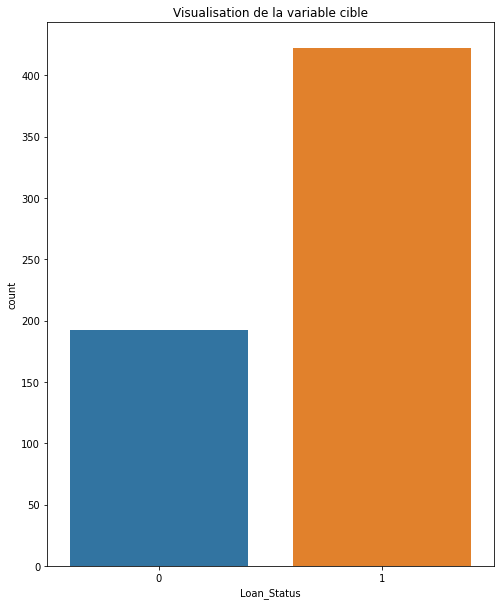

In [ ]:
# visualisation des credits accepté et refusé
fig = plt.figure(figsize=(8,10))
sbn.countplot(target)
# calcul de pourcentage de oui et non
yes = target.value_counts()[0] /len(target)
no = target.value_counts()[1] /len(target)
print(f"le pourcentage de credit accepté est:{round(yes, 2)}")
print(f"le pourcentage de credit non accepté est:{round(no, 2)}")
plt.title('Visualisation de la variable cible')


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


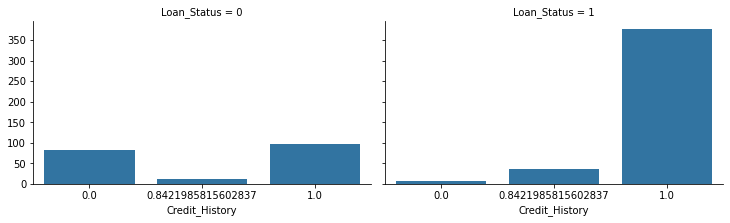

In [ ]:
# Visualiser l'historique de credit (bon historique '1' = plus de credit accepté)
grid= sbn.FacetGrid(df,col='Loan_Status', size=3.2, aspect=1.6)
grid.map(sbn.countplot, 'Credit_History')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


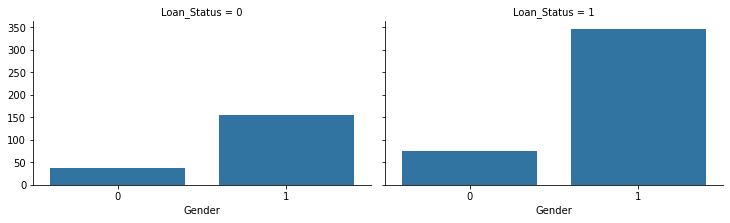

In [ ]:
# Visualiser l'historique de credit (homme '1' = plus de credit accepté)
grid= sbn.FacetGrid(df,col='Loan_Status', size=3.2, aspect=1.6)
grid.map(sbn.countplot, 'Gender')

In [ ]:
# Division de dataSet en train et test, la methode StratifiedShuffleSplit est utilisé car 
#la population statistique peut etre facilement divisé en sous groupe distinct(Gender, Married ... )
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train, test in sss.split(X,y):
  X_train, X_test =X.iloc[train], X.iloc[test]
  y_train, y_test = y.iloc[train], y.iloc[test]
print('taille de X_train: ', X_train.shape)
print('taille de X_test: ', X_test.shape)
print('taille de y_train: ', y_train.shape)
print('taille de y_test: ', y_test.shape)

taille de X_train:  (491, 11)
taille de X_test:  (123, 11)
taille de y_train:  (491,)
taille de y_test:  (123,)


A cette etape, je vais commencer la prepation de mon modèle.Je vais evaluer 3 modeles et leur performance pour trouver le meilleur.

In [ ]:
# algerithme choisi: logistic Regression, KNN, DecisionTree

models={'LogisticRegression': LogisticRegression(random_state=42, solver='liblinear'),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=42)
}
# fonction de precision: permet d'evaluer la performance d'une model
def accu(y_true, y_pred, retu=False):
  acc = accuracy_score(y_true, y_pred)
  if retu:
    return acc
  else:
    print(f"la performance du model est de {round(acc, 2)}")

# fonction entrainement et prediction, evaluation des performances
def train_test_evaluate(X_train, X_test, y_train, y_test, models):
  for name, model in models.items():
    print(name,':')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accu(y_test, predictions)
    print('-'*30) # pour la separation

train_test_evaluate(X_train, X_test, y_train, y_test, models)


LogisticRegression :
la performance du model est de 0.86
------------------------------
KNeighborsClassifier :
la performance du model est de 0.65
------------------------------
DecisionTreeClassifier :
la performance du model est de 0.85
------------------------------


Reduire le set de train aux variables qui impact le modele, la regression logistique à la meilleur performance donc le model de choix. Appliquer ce modele sur notre X2
- Enregistrer le modele puis le deployer avec Flask


In [ ]:
# Logistic Regression Model
logm = LogisticRegression(random_state=42, solver='liblinear')
logm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Pkl_Filename = "Pickle_RLogistic_Model.pkl"  
 
pickle.dump(logm, open(Pkl_Filename, 'wb'))